### Installing and Importing Libraries. Defining functions

In [1]:
!pip install pyyaml==5.1 -q
!pip install 'git+https://github.com/facebookresearch/detectron2.git' -q
!pip install git+https://github.com/PatBall1/detectree2.git -q
!pip install fiftyone -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import sys, os, distutils.core
import torch
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
import yaml
import matplotlib.pyplot as plt
from glob import glob
import random
import sklearn.metrics as skm

from detectron2.modeling import build_model
from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

from detectree2.models.train import setup_cfg

import fiftyone as fo



def get_random_tif_path(folder):
    all_tifs = glob(os.path.join(folder, '*.tif'))
    return random.choice(all_tifs)


def remove_ds(ds_name):
    DatasetCatalog.remove(ds_name)
    MetadataCatalog.remove(ds_name)


def visualise_preds(cv_img, pred_outputs, scale=1.2, metadata=None, i_class=None):
    if type(i_class)==int:
        pred_outputs = {"instances": outputs['instances'][outputs['instances'].pred_classes==i_class]}
    v = Visualizer(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB), scale=scale, metadata=metadata)
    v = v.draw_instance_predictions(pred_outputs["instances"].to("cpu"))
    cv2_imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_RGB2BGR))
    return None


def detectron_to_fo(outputs, img_w, img_h, map_dict):
    # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    detections = []
    instances = outputs["instances"].to("cpu")
    for pred_box, score, c, mask in zip(
        instances.pred_boxes, instances.scores, instances.pred_classes, instances.pred_masks,
    ):
        x1, y1, x2, y2 = pred_box
        fo_mask = mask.numpy()[int(y1):int(y2), int(x1):int(x2)]
        bbox = [float(x1)/img_w, float(y1)/img_h, float(x2-x1)/img_w, float(y2-y1)/img_h]
        label = map_dict[c.item()]
        detection = fo.Detection(label=label, confidence=float(score), bounding_box=bbox, mask=fo_mask)
        detections.append(detection)

    return fo.Detections(detections=detections)

Migrating database to v0.23.8


INFO:fiftyone.migrations.runner:Migrating database to v0.23.8


### Set up custom variables

In [97]:
detectron_dir = "/content/drive/MyDrive/Mhadei Restoration Research/Detectron2/"
model_output_dir = os.path.join(detectron_dir, "Detectron2_1st_train")
model_cp = os.path.join(detectron_dir, "230103_randresize_full.pth")

train_label_path= "/content/drive/MyDrive/Mhadei Restoration Research/Data for ML Work/coco-Yolo-iteration-II-train.json"
train_image_path= "/content/drive/MyDrive/Mhadei Restoration Research/Data for ML Work/Yolo-iteration-II/train/images"
val_label_path= "/content/drive/MyDrive/Mhadei Restoration Research/Data for ML Work/coco-Yolo-iteration-II-val.json"
val_image_path= "/content/drive/MyDrive/Mhadei Restoration Research/Data for ML Work/Yolo-iteration-II/val/images"


model_classes = 8

cfg_path = os.path.join(model_output_dir, 'config.yaml')

test_image_folder = "/content/drive/MyDrive/Mhadei Restoration Research/Data for ML Work/Original-Data/images_orthos/"

### Setting up Datasets

In [103]:
cfg = setup_cfg(update_model=model_cp)

register_coco_instances(
    "my_dataset_train",
     {},
    train_label_path,
    train_image_path
    )
register_coco_instances(
    "my_dataset_val",
     {},
    val_label_path,
    val_image_path
    )

train_dataset_dicts = DatasetCatalog.get("my_dataset_train")
train_metadata = MetadataCatalog.get("my_dataset_train")

val_dataset_dicts = DatasetCatalog.get("my_dataset_val")
val_metadata = MetadataCatalog.get("my_dataset_val")

# Visualize some random samples
# for d in random.sample(train_dataset_dicts, 2):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image()[:, :, ::-1])
#     plt.show()

[05/27 09:45:46 d2.data.datasets.coco]: Loaded 23 images in COCO format from /content/drive/MyDrive/Mhadei Restoration Research/Data for ML Work/coco-Yolo-iteration-II-train.json
[05/27 09:45:46 d2.data.datasets.coco]: Loaded 11 images in COCO format from /content/drive/MyDrive/Mhadei Restoration Research/Data for ML Work/coco-Yolo-iteration-II-val.json


### Training

In [104]:
cfg.OUTPUT_DIR = os.path.join(detectron_dir, 'Detectron2_Current')
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = model_classes  # NOTE: number of classes excluding background. Do not use num_classes+1 here.

# setting up test args
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.TEST.EVAL_PERIOD = 10
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

In [105]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

config_yaml_path = os.path.join(cfg.OUTPUT_DIR, 'config.yaml')
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

[05/27 09:45:55 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[05/27 09:46:08 d2.engine.train_loop]: Starting training from iteration 0
[05/27 09:46:25 d2.data.datasets.coco]: Loaded 11 images in COCO format from /content/drive/MyDrive/Mhadei Restoration Research/Data for ML Work/coco-Yolo-iteration-II-val.json
[05/27 09:46:25 d2.data.build]: Distribution of instances among all 8 categories:
|   category    | #instances   |   category    | #instances   |  category  | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:----------:|:-------------|
| Distorted I.. | 12           |  Canopy Gap   | 24           | Bare Land  | 25           |
|  Plantation   | 7            | Potential I.. | 3            |  Unknown   | 0            |
| Potential C.. | 0            |     Cane      | 0            |            |              |
|     total     | 71           |               |              |            |              |
[05/27 09:46:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short

KeyboardInterrupt: 

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/detectron2_temp

### Testing

In [80]:
cfg.merge_from_file(cfg_path)
cfg.OUTPUT_DIR = model_output_dir

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set a custom testing threshold
predictor = DefaultPredictor(cfg)

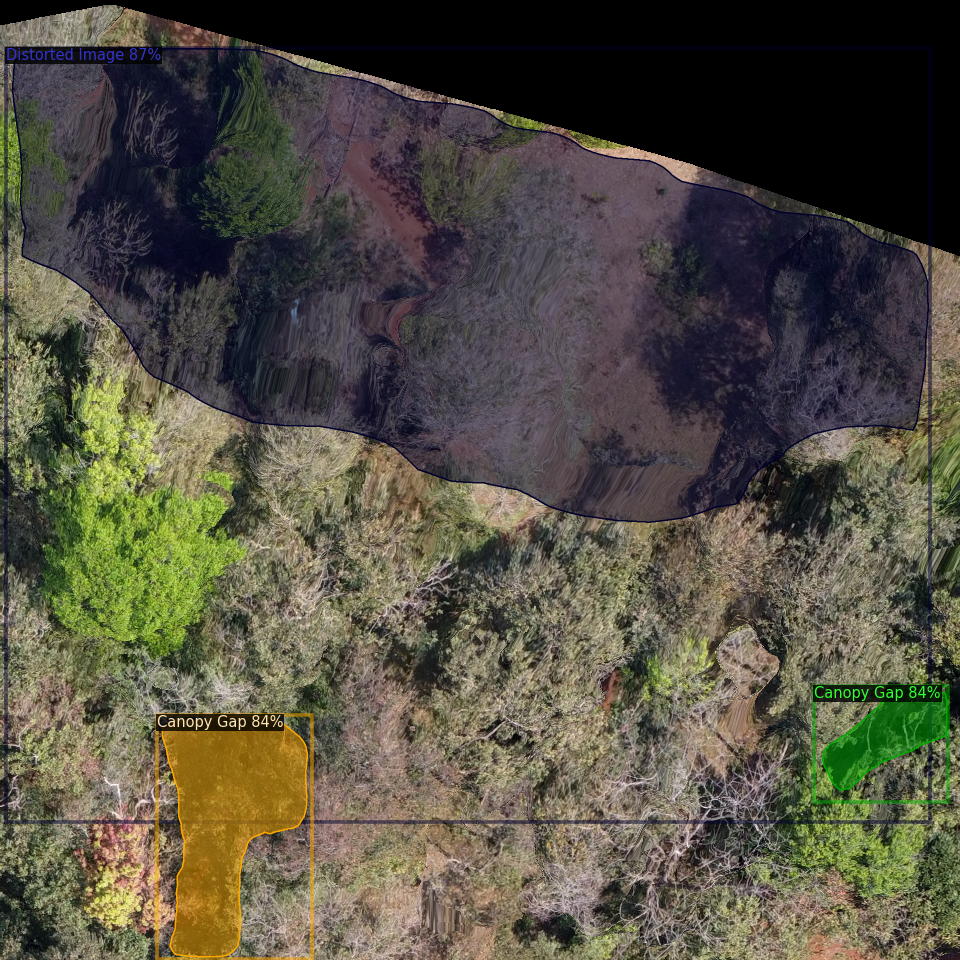

In [10]:
# testing predictions on random image
image_path = get_random_tif_path(test_image_folder)

img = cv2.imread(image_path)
outputs = predictor(img)

visualise_preds(img, outputs, 0.5, metadata=train_metadata, i_class=None)

### Using FiftyOne for Metrics

In [60]:
# Import the dataset
dataset_train = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=train_image_path,
    labels_path=train_label_path,
)


dataset_val = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=val_image_path,
    labels_path=val_label_path,
)

dict_detectron_id_to_file = dict()
for item in val_dataset_dicts:
    dict_detectron_id_to_file[item['image_id']] = item['file_name']

dict_file_to_fo_id = {i:j for i, j in zip(dataset_val.values('filepath'), dataset_val.values('id'))}

id_to_label_dict = dict()
for k, v in val_metadata.thing_dataset_id_to_contiguous_id.items():
    id_to_label_dict[v] = val_metadata.thing_classes[v]

 100% |███████████████████| 23/23 [2.7s elapsed, 0s remaining, 8.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 23/23 [2.7s elapsed, 0s remaining, 8.6 samples/s]      


 100% |███████████████████| 11/11 [760.4ms elapsed, 0s remaining, 14.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 11/11 [760.4ms elapsed, 0s remaining, 14.6 samples/s]      


In [81]:
# getting predictions and saving them
predictions = {}
for d in val_dataset_dicts:
    img_w = d["width"]
    img_h = d["height"]
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)
    detections = detectron_to_fo(outputs, img_w, img_h, id_to_label_dict)
    fo_image_id = dict_file_to_fo_id[dict_detectron_id_to_file[d['image_id']]]
    predictions[fo_image_id] = detections

dataset_val.set_values("predictions", predictions, key_field="id")

In [84]:
# to compute metrics and add metric-based views
results = dataset_val.evaluate_detections(
    "predictions",
    gt_field="segmentations",
    eval_key="eval",
    use_masks=True,
    compute_mAP=True,
    iou=0.5
)

Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████████| 11/11 [2.6s elapsed, 0s remaining, 4.3 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 11/11 [2.6s elapsed, 0s remaining, 4.3 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████████| 11/11 [1.3s elapsed, 0s remaining, 8.4 samples/s]         


INFO:eta.core.utils: 100% |███████████████████| 11/11 [1.3s elapsed, 0s remaining, 8.4 samples/s]         


In [85]:
overall_map = results.mAP() # not sure the ious considered here
conf_matrix, labels, _ = results._confusion_matrix()
normalised_conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True)

# below code taken from the print_report function code
labels = results._parse_classes(None)
report_dict = skm.classification_report(
    results.ytrue,
    results.ypred,
    labels=labels,
    digits=2,
    sample_weight=None,
    zero_division=0,
    output_dict=True
)
overall_metrics = results.metrics()

ToDo:
* Generalise properly for train too
* Crosscheck if metrics are the same here and in the original outputs by detectron2